<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Data_Sets_Versions_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def analyze_images(folder_path):
    image_count = 0
    resolutions = {}
    formats = {}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    image_count += 1

                    resolution = img.size
                    resolutions[resolution] = resolutions.get(resolution, 0) + 1

                    img_format = img.format
                    formats[img_format] = formats.get(img_format, 0) + 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return image_count, resolutions, formats


train_folder = r"/content/drive/MyDrive/dataset/train_images"
test_folder = r"/content/drive/MyDrive/dataset/test_images"

print("Analyzing Training Dataset...")
train_count, train_resolutions, train_formats = analyze_images(train_folder)
print(f"Total Training Images: {train_count}")
print(f"Training Image Resolutions: {train_resolutions}")
print(f"Training Image Formats: {train_formats}")

Analyzing Training Dataset...
Total Training Images: 3662
Training Image Resolutions: {(1050, 1050): 974, (2588, 1958): 533, (2896, 1944): 34, (3216, 2136): 410, (3388, 2588): 141, (1504, 1000): 92, (819, 614): 287, (2416, 1736): 638, (2048, 1536): 351, (1844, 1226): 61, (2144, 1424): 28, (4288, 2848): 52, (1476, 1117): 14, (640, 480): 42, (1467, 1110): 2, (2146, 1764): 1, (474, 358): 2}
Training Image Formats: {'PNG': 3662}


In [ ]:
print("\nAnalyzing Testing Dataset...")
test_count, test_resolutions, test_formats = analyze_images(test_folder)
print(f"Total Testing Images: {test_count}")
print(f"Testing Image Resolutions: {test_resolutions}")
print(f"Testing Image Formats: {test_formats}")


Analyzing Testing Dataset...
Total Testing Images: 1928
Testing Image Resolutions: {(1476, 1117): 2, (640, 480): 1403, (2588, 1958): 134, (2416, 1736): 225, (2048, 1536): 28, (2896, 1944): 11, (1050, 1050): 69, (819, 614): 45, (2592, 1944): 6, (768, 576): 2, (1467, 1110): 2, (2146, 1764): 1}
Testing Image Formats: {'PNG': 1928}


In [ ]:
def analyze_csv(file_path, dataset_name):
    try:
        data = pd.read_csv(file_path)

        print(f"\nAnalyzing {dataset_name} Dataset Metadata...")
        print(f"Number of Rows: {data.shape[0]}")
        print(f"Number of Columns: {data.shape[1]}")
        print("\nColumn Names:")
        print(data.columns)

        print("\nMissing Values Per Column:")
        print(data.isnull().sum())

        print("\nUnique Values in Each Column:")
        for column in data.columns:
            print(f"{column}: {data[column].nunique()} unique values")

        if 'label' in data.columns or 'diagnosis' in data.columns:  # Assuming the column might be 'label' or 'diagnosis'
            label_column = 'label' if 'label' in data.columns else 'diagnosis'
            print(f"\nDistribution of {label_column} Labels:")
            print(data[label_column].value_counts())

    except Exception as e:
        print(f"Error reading {file_path}: {e}")


train_csv = r"/content/drive/MyDrive/dataset/train.csv"
test_csv = r"/content/drive/MyDrive/dataset/test.csv"

analyze_csv(train_csv, "Training")


Analyzing Training Dataset Metadata...
Number of Rows: 3662
Number of Columns: 2

Column Names:
Index(['id_code', 'diagnosis'], dtype='object')

Missing Values Per Column:
id_code      0
diagnosis    0
dtype: int64

Unique Values in Each Column:
id_code: 3662 unique values
diagnosis: 5 unique values

Distribution of diagnosis Labels:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


In [ ]:
analyze_csv(test_csv, "Testing")


Analyzing Testing Dataset Metadata...
Number of Rows: 1928
Number of Columns: 1

Column Names:
Index(['id_code'], dtype='object')

Missing Values Per Column:
id_code    0
dtype: int64

Unique Values in Each Column:
id_code: 1928 unique values


# Visualization 1: Sample Images for Each Class

Class 0: 1805 samples


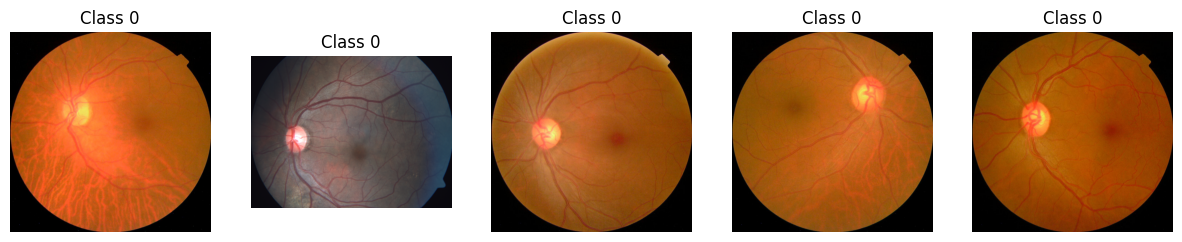

Class 1: 370 samples


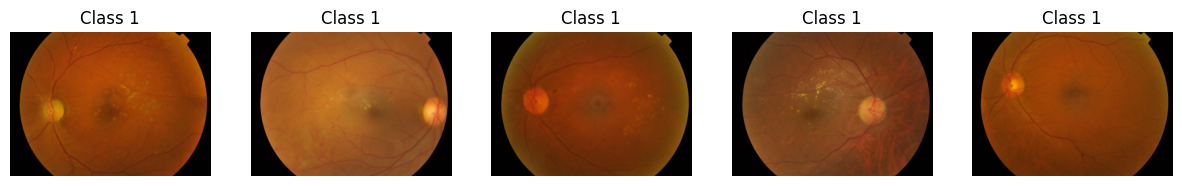

Class 2: 999 samples


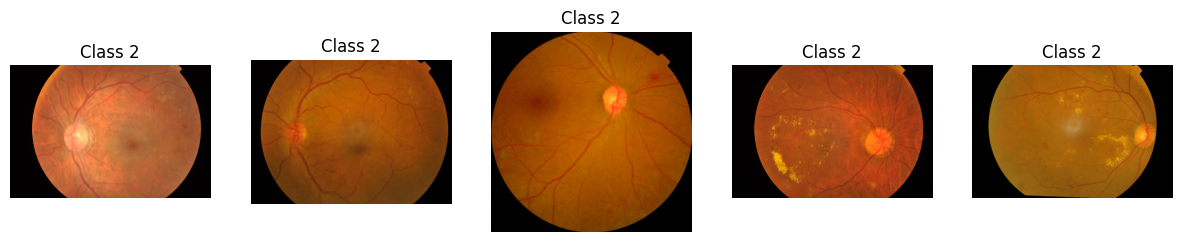

Class 3: 193 samples


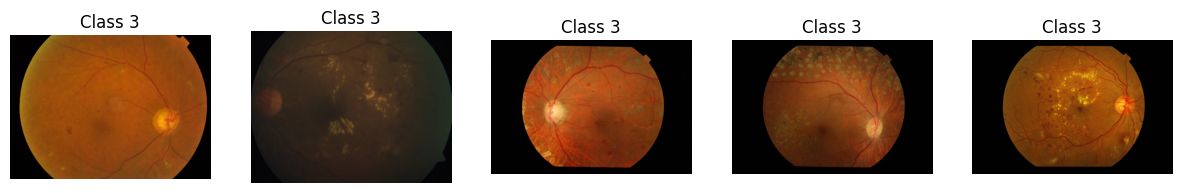

Class 4: 295 samples


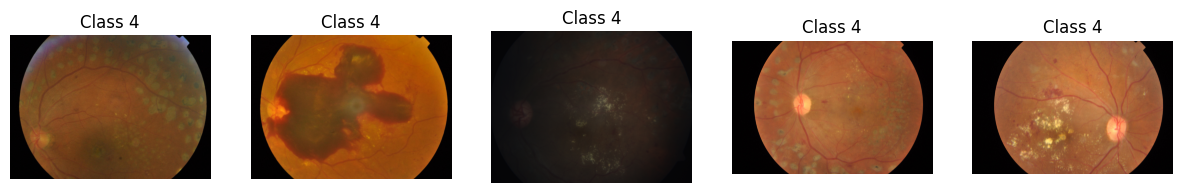

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Visualize sample images for each class
def visualize_samples(folder_path, csv_path, num_samples=5):
    import pandas as pd
    data = pd.read_csv(csv_path)
    diagnosis_groups = data.groupby('diagnosis')

    for diagnosis, group in diagnosis_groups:
        print(f"Class {diagnosis}: {len(group)} samples")
        sample_ids = group['id_code'].sample(num_samples, random_state=42).values
        plt.figure(figsize=(15, 5))
        for i, sample_id in enumerate(sample_ids):
            file_path = os.path.join(folder_path, f"{sample_id}.png")
            if os.path.exists(file_path):
                img = Image.open(file_path)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.title(f"Class {diagnosis}")
                plt.axis('off')
        plt.show()

visualize_samples(train_folder, train_csv)


# Visualization 2: Class Distribution in Training Data



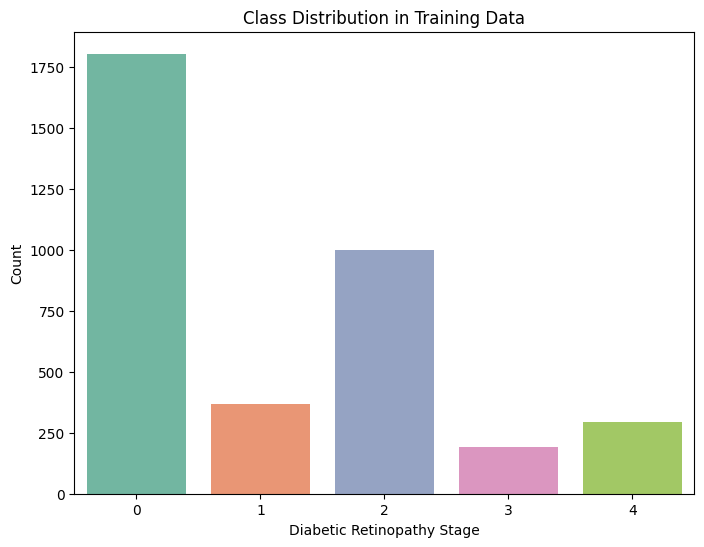

In [ ]:
# Load training CSV
data = pd.read_csv(train_csv)

plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', hue='diagnosis', data=data, palette='Set2', legend=False)
plt.title("Class Distribution in Training Data")
plt.xlabel("Diabetic Retinopathy Stage")
plt.ylabel("Count")
plt.show()

# healthy and non healthy data set creatation

In [23]:
import pandas as pd
import os
import shutil

train_csv = r"/content/drive/MyDrive/dataset/train.csv"
train_df = pd.read_csv(train_csv)

train_df['binary_label'] = train_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

base_dir = r"/content/drive/MyDrive/dataset/binary_dataset"
healthy_dir = os.path.join(base_dir, "healthy")
non_healthy_dir = os.path.join(base_dir, "non_healthy")

os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(non_healthy_dir, exist_ok=True)

train_images_dir = r"/content/drive/MyDrive/dataset/train_images"

for index, row in train_df.iterrows():
    image_name = row['id_code'] + ".png"
    src_path = os.path.join(train_images_dir, image_name)

    if row['binary_label'] == 0:
        dest_path = os.path.join(healthy_dir, image_name)
    else:
        dest_path = os.path.join(non_healthy_dir, image_name)

    shutil.copy(src_path, dest_path)

print("Binary dataset created successfully!")

Binary dataset created successfully!


In [24]:
def verify_binary_dataset(base_dir):
    healthy_dir = os.path.join(base_dir, "healthy")
    non_healthy_dir = os.path.join(base_dir, "non_healthy")

    healthy_images = os.listdir(healthy_dir)
    healthy_count = len(healthy_images)

    non_healthy_images = os.listdir(non_healthy_dir)
    non_healthy_count = len(non_healthy_images)

    print(f"Number of Healthy Images: {healthy_count}")
    print(f"Number of Non-Healthy Images: {non_healthy_count}")
    print(f"Total Images: {healthy_count + non_healthy_count}")

    print("\nVerifying image integrity")
    for folder in [healthy_dir, non_healthy_dir]:
        for image_name in os.listdir(folder):
            image_path = os.path.join(folder, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except Exception as e:
                print(f"Error in image {image_name}: {e}")


binary_dataset_dir = r"/content/drive/MyDrive/dataset/binary_dataset"

verify_binary_dataset(binary_dataset_dir)

Number of Healthy Images: 1805
Number of Non-Healthy Images: 1857
Total Images: 3662

Verifying image integrity


# Oversample balanced data set

In [37]:
import os
import shutil
import random

binary_dataset_dir = r"/content/drive/MyDrive/dataset/binary_dataset"
balanced_dataset_dir = r"/content/drive/MyDrive/dataset/balanced_dataset"

balanced_healthy_dir = os.path.join(balanced_dataset_dir, "healthy")
balanced_non_healthy_dir = os.path.join(balanced_dataset_dir, "non_healthy")

os.makedirs(balanced_healthy_dir, exist_ok=True)
os.makedirs(balanced_non_healthy_dir, exist_ok=True)

non_healthy_images = os.listdir(os.path.join(binary_dataset_dir, "non_healthy"))
for image_name in non_healthy_images:
    src_path = os.path.join(binary_dataset_dir, "non_healthy", image_name)
    dest_path = os.path.join(balanced_non_healthy_dir, image_name)
    shutil.copy(src_path, dest_path)

healthy_images = os.listdir(os.path.join(binary_dataset_dir, "healthy"))
num_healthy = len(healthy_images)
num_non_healthy = len(non_healthy_images)

additional_images_needed = num_non_healthy - num_healthy

additional_images = random.choices(healthy_images, k=additional_images_needed)

for image_name in healthy_images:
    src_path = os.path.join(binary_dataset_dir, "healthy", image_name)
    dest_path = os.path.join(balanced_healthy_dir, image_name)
    shutil.copy(src_path, dest_path)

for image_name in additional_images:
    src_path = os.path.join(binary_dataset_dir, "healthy", image_name)
    dest_path = os.path.join(balanced_healthy_dir, "oversampled_" + image_name)
    shutil.copy(src_path, dest_path)

print("Balanced dataset created successfully!")

Balanced dataset created successfully!


In [38]:
verify_binary_dataset(balanced_dataset_dir)

Number of Healthy Images: 1857
Number of Non-Healthy Images: 1857
Total Images: 3714

Verifying image integrity


# Undersample balanced data set

In [27]:
binary_dataset_dir = r"/content/drive/MyDrive/dataset/binary_dataset"
undersampled_dataset_dir = r"/content/drive/MyDrive/dataset/undersampled_dataset"

undersampled_healthy_dir = os.path.join(undersampled_dataset_dir, "healthy")
undersampled_non_healthy_dir = os.path.join(undersampled_dataset_dir, "non_healthy")

os.makedirs(undersampled_healthy_dir, exist_ok=True)
os.makedirs(undersampled_non_healthy_dir, exist_ok=True)

healthy_images = os.listdir(os.path.join(binary_dataset_dir, "healthy"))
for image_name in healthy_images:
    src_path = os.path.join(binary_dataset_dir, "healthy", image_name)
    dest_path = os.path.join(undersampled_healthy_dir, image_name)
    shutil.copy(src_path, dest_path)

non_healthy_images = os.listdir(os.path.join(binary_dataset_dir, "non_healthy"))
num_healthy = len(healthy_images)
num_non_healthy = len(non_healthy_images)

undersampled_non_healthy_images = random.sample(non_healthy_images, num_healthy)

for image_name in undersampled_non_healthy_images:
    src_path = os.path.join(binary_dataset_dir, "non_healthy", image_name)
    dest_path = os.path.join(undersampled_non_healthy_dir, image_name)
    shutil.copy(src_path, dest_path)

print("Undersampled balanced dataset created successfully!")

Undersampled balanced dataset created successfully!


In [28]:
verify_binary_dataset(undersampled_dataset_dir)

Number of Healthy Images: 1805
Number of Non-Healthy Images: 1805
Total Images: 3610

Verifying image integrity


#Balanced dataset with 1500 images per class

In [29]:
binary_dataset_dir = r"/content/drive/MyDrive/dataset/binary_dataset"
balanced_1500_dataset_dir = r"/content/drive/MyDrive/dataset/balanced_1500_dataset"

balanced_1500_healthy_dir = os.path.join(balanced_1500_dataset_dir, "healthy")
balanced_1500_non_healthy_dir = os.path.join(balanced_1500_dataset_dir, "non_healthy")

os.makedirs(balanced_1500_healthy_dir, exist_ok=True)
os.makedirs(balanced_1500_non_healthy_dir, exist_ok=True)

def copy_random_images(source_dir, destination_dir, num_images):
    all_images = os.listdir(source_dir)
    selected_images = random.sample(all_images, num_images)
    for image_name in selected_images:
        src_path = os.path.join(source_dir, image_name)
        dest_path = os.path.join(destination_dir, image_name)
        shutil.copy(src_path, dest_path)

copy_random_images(
    source_dir=os.path.join(binary_dataset_dir, "healthy"),
    destination_dir=balanced_1500_healthy_dir,
    num_images=1500
)

copy_random_images(
    source_dir=os.path.join(binary_dataset_dir, "non_healthy"),
    destination_dir=balanced_1500_non_healthy_dir,
    num_images=1500
)

print("Balanced dataset with 1500 images per class created successfully!")

Balanced dataset with 1500 images per class created successfully!


In [30]:
verify_binary_dataset(balanced_1500_dataset_dir)

Number of Healthy Images: 1500
Number of Non-Healthy Images: 1500
Total Images: 3000

Verifying image integrity


# Balanced dataset with 2500 images

In [31]:
binary_dataset_dir = r"/content/drive/MyDrive/dataset/binary_dataset"
balanced_2500_dataset_dir = r"/content/drive/MyDrive/dataset/balanced_2500_dataset"

balanced_2500_healthy_dir = os.path.join(balanced_2500_dataset_dir, "healthy")
balanced_2500_non_healthy_dir = os.path.join(balanced_2500_dataset_dir, "non_healthy")

os.makedirs(balanced_2500_healthy_dir, exist_ok=True)
os.makedirs(balanced_2500_non_healthy_dir, exist_ok=True)

def oversample_and_copy_images(source_dir, destination_dir, num_images):
    all_images = os.listdir(source_dir)
    num_existing_images = len(all_images)

    for image_name in all_images:
        src_path = os.path.join(source_dir, image_name)
        dest_path = os.path.join(destination_dir, image_name)
        shutil.copy(src_path, dest_path)

    additional_images_needed = num_images - num_existing_images

    additional_images = random.choices(all_images, k=additional_images_needed)

    for i, image_name in enumerate(additional_images):
        src_path = os.path.join(source_dir, image_name)
        dest_path = os.path.join(destination_dir, f"oversampled_{i}_{image_name}")
        shutil.copy(src_path, dest_path)

oversample_and_copy_images(
    source_dir=os.path.join(binary_dataset_dir, "healthy"),
    destination_dir=balanced_2500_healthy_dir,
    num_images=2500
)

oversample_and_copy_images(
    source_dir=os.path.join(binary_dataset_dir, "non_healthy"),
    destination_dir=balanced_2500_non_healthy_dir,
    num_images=2500
)

print("Balanced dataset with 2500 images per class created successfully!")

Balanced dataset with 2500 images per class created successfully!


In [32]:
verify_binary_dataset(balanced_2500_dataset_dir)

Number of Healthy Images: 2500
Number of Non-Healthy Images: 2500
Total Images: 5000

Verifying image integrity
